# Minimization

When using a Maximum Likelihood analysis we want to find the maximum of the likelihood $L(\vec{\theta})$ given one or more datasets (i.e., plugin instances) and one model containing one or more sources with free parameters $\vec{\theta}$. Most of the available algorithms for function optimization find the minimum, not the maximum, of a function. Also, since the likelihood function is usually the product of many probabilities, bounded to be $0 < p < 1$, $L(\vec{\theta})$ tend to be very small. Hence, it is much more tractable numerically to deal with the logarithm of the likelihood. Therefore, instead of finding the maximum of the likelihood $L$, we find the minimum of the $-\log{L(\vec{\theta})}$ function. Of course, the values of $\vec{\theta}$ minimizing $-\log{L}$ are the same that maximize $L$, i.e.:

argmax$_{\vec{\theta}}~\left( L(\vec{\theta}) \right)$ = argmin$_{\vec{\theta}}~\left(-\log{L(\vec{\theta})}\right)$.

Various minimizers are available in 3ML. We can divide them in two groups: local minimizers and global minimizers.

## Local minimizers

Most of the existing optimization algorithms are local minimizers (MINUIT, Levenberg–Marquardt, Netwton...).
A local minimizer starts from the current values for the free parameters $\vec{\theta}$ and try to reach the closest minimum of a function $f(\vec{\theta})$ (in 3ML this is usually the $-\log{L}$).

Many minimizers are based on the idea of gradient descent, i.e., they compute the local gradient of $f(\vec{\theta})$ and follow the function along the direction of steepest discent until the minimum. There are however also gradient-free algorithms, like for example [COBYLA](http://www.pyopt.org/reference/optimizers.cobyla.html). While going into the details of how each algorithm works is beyond the scope, we illustrate here an example by using the Minuit algorithm.

Let's start by importing what we need in the following:

In [1]:
from threeML import *

import matplotlib.pyplot as plt

%matplotlib inline


from threeML.minimizer.tutorial_material import *

Configuration read from /home/giacomov/.threeML/threeML_config.yml
Plotter is MatPlotlib


Let's get a JointLikelihood object like the one we would have in a normal 3ML analysis. We use a custom function, prepared for this tutorial, which gives a JointLikelihood object having a very simple model with one free parameter ($\mu$), and with a likelihood having a very simple shape:

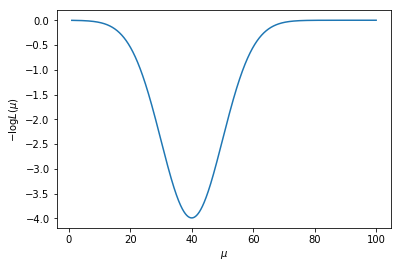

In [2]:
# This returns a JointLikelihood object with a simple likelihood function,
# and the corresponding Model instance. These objects are what you will have
# in a typical 3ML analysis. The Model contains one point source, named "test",
# with a spectrum called "simple"
jl, model = get_joint_likelihood_object_simple_likelihood()

# Let's look at the likelihood function, which in this illustrative example
# has a very simple shape
_ = plot_likelihood_function(jl)

Now let's set up the Minuit minimizer and minimize the -log(L), starting from $\mu = 1$:

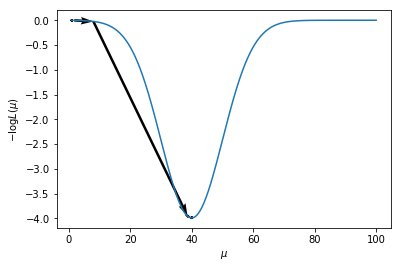

In [3]:
model.test.spectrum.main.shape.mu = 1.0

# The minuit minimizer is the default, so no setup is necessary
# quiet = True means that no result will be printed
res = jl.fit(quiet=True)

# This plots the path that Minuit has traveled looking for the minimum
# Arrows connect the different points, starting from 1.0 and going
# to 40, the minimum

fig = plot_minimizer_path(jl)

Now let's do the same, but starting from $\mu=80$:

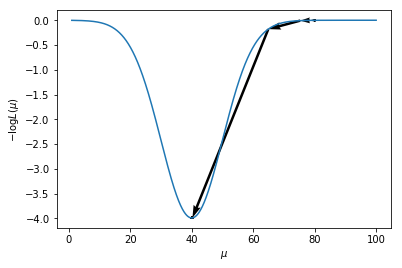

In [4]:
model.test.spectrum.main.shape.mu = 80.0
res = jl.fit(quiet=True)
fig = plot_minimizer_path(jl)

and from $\mu=20$:

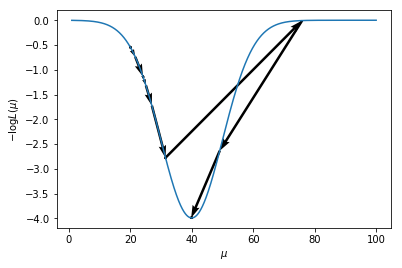

In [5]:
model.test.spectrum.main.shape.mu = 20.0
res = jl.fit(quiet=True)
fig = plot_minimizer_path(jl)

It is clear that, depending on the starting point, minuit makes different steps trying to reach the minimum. In this last case, at one point Minuit overshoots the minimum jumping all the way from $\sim 30$ to $\sim 80$, then realizes the mistake and goes back.

In the case of a simple, convex likelihood like this one, Minuit finds easily the minimum independently of the starting point.

## Global minimization

Now let us consider the case of a more complicated $-\log{L}$ function:

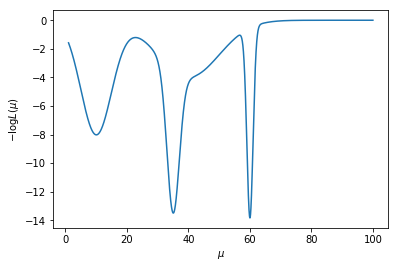

In [6]:
jl, model = get_joint_likelihood_object_complex_likelihood()

_ = plot_likelihood_function(jl)

This likelihood function has 3 minima: 2 are local and one (at $\mu = 60$) is the global minimum. Let's see how Minuit performs in this case. First we start from 1.0:

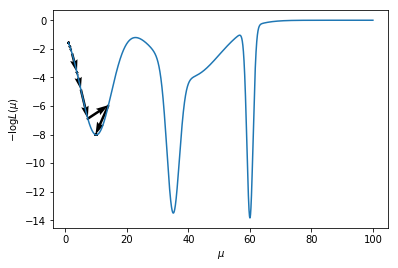

In [7]:
model.test.spectrum.main.shape.mu = 1.0

res = jl.fit(quiet=True)

fig = plot_minimizer_path(jl)

Minuit has found the local minimum, not the global one. Now we start from 80:

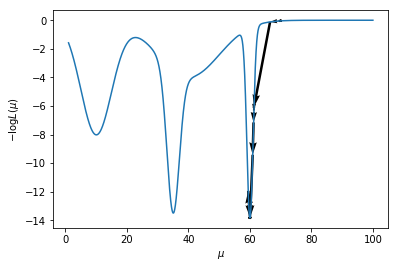

In [8]:
model.test.spectrum.main.shape.mu = 70

res = jl.fit(quiet=True)

fig = plot_minimizer_path(jl)

Now we found the global minimum. This is a simple example to show that the solution find by a local minimizers can depend on the starting point, and might not be the global minimum. In practice, one can rarely be guaranteed that the likelihood function has only one minimum. This is especially true in many dimensions and in cases of data with poor statistic. 

To alleviate this problem 3ML offers some "global minimizers". While it is impossible to guarantee that a global minimum will be reached, these minimizers are much more robust towards this kind of problems, at the expenses of a considerable longer runtime.

In 3ML each global minimizer must be associated with a local minimizer. The latter is used as final step to improve the solution found by the global minimizer and to compute the error matrix.

### Grid minimizer

The idea behind this is very simple: the user defines a grid of values for the parameters, which are used as starting points for minimization performed by a local minimizers. At the end, the solution with the smallest value for $-\log{L}$ will be used as final solution.

For example, let's define a grid of 10 values for $\mu$. This means that 3ML will perform 10 local minimizations starting each time from a different point in the grid:



Results after global minimizer (before secondary optimization):


,result,unit
parameter,,
test.spectrum.main.Complex.mu,(5.999 +/- 0) x 10,keV



Total log-likelihood minimum: -13.838

Best fit values:



,result,unit
parameter,,
test.spectrum.main.Complex.mu,(5.999 +/- 0.027) x 10,keV



Correlation matrix:



1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
custom,-13.838425
total,-13.838425



Values of statistical measures:



,statistical measures
AIC,-29.676849
BIC,-27.676849


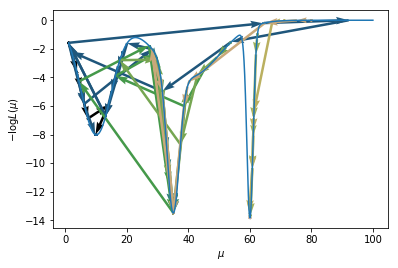

In [9]:
# Create an instance of the GRID minimizer
grid_minimizer = GlobalMinimization("grid")
    
# Create an instance of a local minimizer, which will be used by GRID
local_minimizer = LocalMinimization("minuit")

# Define a grid for mu as 10 steps between 1 and 80
my_grid = {model.test.spectrum.main.shape.mu: np.linspace(1, 80, 10)}

# Setup the global minimization
# NOTE: the "callbacks" option is useless in a normal 3ML analysis, it is
# here only to keep track of the evolution for the plot
grid_minimizer.setup(second_minimization=local_minimizer, grid = my_grid, 
                     callbacks=[get_callback(jl)])

# Set the minimizer for the JointLikelihood object
jl.set_minimizer(grid_minimizer)

jl.fit()

fig = plot_minimizer_path(jl)

The GRID minimizer has found the global minimum.

Of course the GRID minimizer can be used in multiple dimensions (simply define a grid for the other parameters as well). It is a simple brute force solution that works well in practice, especially when the likelihood function computation is not too time-consuming. When there are many parameters, you should choose carefully the parameters to use in the grid. For example, when looking for a spectral line in a spectrum, it makes sense to use the location of the line as parameter in the grid, but not its normalization. 

### PAGMO minimizer

The Pagmo minimizer is an open-source optimization suite provided by the European Space Agency:

https://esa.github.io/pagmo2/

It contains a lot of algorithms for optimization of different kinds:

https://esa.github.io/pagmo2/docs/algorithm_list.html

and it is very powerful. In order to be able to use it you need to install the python package pygmo (make sure to have version >= 2, as the old version 1.x has a different API and won't work with 3ML).

In Pagmo/pygmo, candidate solutions to the minimization are called "individuals". A population of individuals over which an algorithm acts to improve the solutions is called "island". An ensamble of islands that can share solutions along a defined topology and thus learn on their reciprocal progress is called "archipelago". The evolution of the populations can be executed more than once ("evolution cycles").

After the pygmo section of the optimization has been completed, the secondary minimizer will be used to further improve on the solution (if possible) and to compute the covariance matrix.

In [10]:
# Reset the parameter to a value different from the best fit found
# by previous algorithms
jl, model = get_joint_likelihood_object_complex_likelihood()
model.test.spectrum.main.shape.mu = 2.5

# Create an instance of the PAGMO minimizer
pagmo_minimizer = GlobalMinimization("pagmo")

# Select one of the many algorithms provided by pagmo
# (see https://esa.github.io/pagmo2/docs/algorithm_list.html
# for a list).
# In this case we use the Artificial Bee Colony algorithm
# (see here for a description: https://link.springer.com/article/10.1007/s10898-007-9149-x)

import pygmo
my_algorithm = pygmo.algorithm(pygmo.bee_colony(gen=20))

# Create an instance of a local minimizer
local_minimizer = LocalMinimization("minuit")

# Setup the global minimization
pagmo_minimizer.setup(second_minimization = local_minimizer, algorithm=my_algorithm,
                      islands=10, population_size=10, evolution_cycles=1)

# Set the minimizer for the JointLikelihood object
jl.set_minimizer(pagmo_minimizer)

jl.fit()

# NOTE: given the inner working of pygmo, it is not possible
# to plot the evolution


PAGMO setup:
------------
- Number of islands:            10
- Population size per island:   10
- Evolutions cycles per island: 1




Summary of evolution:
---------------------
Best population has minimum -13.834
Worst population has minimum -13.496



Results after global minimizer (before secondary optimization):


,result,unit
parameter,,
test.spectrum.main.Complex.mu,(5.997 +/- 0) x 10,keV



Total log-likelihood minimum: -13.834

Best fit values:



,result,unit
parameter,,
test.spectrum.main.Complex.mu,(5.999 +/- 0.027) x 10,keV



Correlation matrix:



1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
custom,-13.838425
total,-13.838425



Values of statistical measures:



,statistical measures
AIC,-29.676849
BIC,-27.676849


### Multinest minimizer

MultiNest is a Bayesian inference tool which calculates the evidence and explores the parameter space which may contain multiple posterior modes and pronounced (curving) degeneracies in moderately high dimensions. It is not strictly a minimizer. However, given its capacity to explore multiple modes of the likelihood function (i.e., multiple local minima), it can be used as a global minimizer.

The Multinest minimizer in 3ML forms a posterior probability using the likelihood multiplied by uniformative priors. The priors are automatically chosen (uniform if the allowed parameter range is less than 2 orders of magnitudes or negative values are allowed, log-uniform otherwise). Then, Multinest is run in multimodal mode (multimodal=True). At the end of the run, among all the values of the $-\log{L}$ traversed by Multinest, the smaller one is chosen as starting point for the local minimizer.



Results after global minimizer (before secondary optimization):


,result,unit
parameter,,
test.spectrum.main.Complex.mu,(5.999 +/- 0) x 10,keV



Total log-likelihood minimum: -13.838

Best fit values:



,result,unit
parameter,,
test.spectrum.main.Complex.mu,(5.999 +/- 0.027) x 10,keV



Correlation matrix:



1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
custom,-13.838425
total,-13.838425



Values of statistical measures:



,statistical measures
AIC,-29.676849
BIC,-27.676849


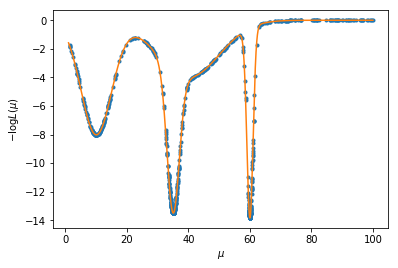

In [11]:
# Reset the parameter to a value different from the best fit found
# by previous algorithms
jl, model = get_joint_likelihood_object_complex_likelihood()
model.test.spectrum.main.shape.mu = 5.0

# Create an instance of the PAGMO minimizer
multinest_minimizer = GlobalMinimization("multinest")

# Create an instance of a local minimizer
local_minimizer = LocalMinimization("minuit")

# Setup the global minimization
multinest_minimizer.setup(second_minimization = local_minimizer, live_points=100)

# Set the minimizer for the JointLikelihood object
jl.set_minimizer(multinest_minimizer)

jl.fit()

# Plots the point traversed by Multinest
fig = plot_minimizer_path(jl, points=True)